# Testing implementation and accuracy of solving SRG flow equations

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ March 1, 2023

The goal of this notebook is to test our implementation of the SRG. We explore different ODE solvers, error tolerances, and different implementations (e.g., solving directly for $U(s)$, or solving with respect to $\lambda$ instead of $s$.)<br>

_Last update:_ March 2, 2023

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from scipy.integrate import ode, solve_ivp
import time

In [2]:
# Imports from scripts
from scripts.figures import interpolate_matrix, set_rc_parameters
from scripts.potentials import Potential

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Set-up

In [4]:
def rms_error_eigenvalues(eigenvalues_initial, eigenvalues_evolved):
    """Calculate the root-mean-square error of the evolved and initial
    eigenvalues.
    """
    
    # Number of eigenvalues
    N = len(eigenvalues_initial)
    
    return np.sqrt(np.sum((eigenvalues_evolved - eigenvalues_initial) ** 2) / N)

In [5]:
def unattach_weights(k_array, k_weights, matrix_weights):
    """Unattach the integration weights from a matrix."""

    # Double the length of the factor_array if coupled-channel
    if len(matrix_weights) == 2*len(k_array):
        factor_array = np.concatenate((
            np.sqrt(2 / np.pi * k_weights) * k_array,
            np.sqrt(2 / np.pi * k_weights) * k_array
        ))
    elif len(matrix_weights) == len(k_array):
        factor_array = np.sqrt(2 / np.pi * k_weights) * k_array
    else:
        raise RuntimeError("Length of matrix_weights is not compatible with "
                           "length of k_array.")
    
    # Create meshgrids to divide out factor of 2/\pi * k_i k_j \sqrt(w_i * w_j)
    row, col = np.meshgrid(factor_array, factor_array, indexing='ij')

    return matrix_weights / row / col

In [6]:
def plot_contour(
        k_array, matrix_no_weights, channel, levels_number=61,
        colorbar_limits=(-1.0,1.0), color_map='turbo', axes_limits=(0.0,10.0),
        xlabel_size=16, ylabel_size=16, label=None,
        label_location='upper right', label_size=16
):
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)

    # --- Plot --- #
    if channel == '3S1-3D1':
        c = ax.contourf(k_array, k_array, matrix_no_weights[:ntot, ntot:],
                        levels, cmap=color_map, extend='both')
    elif channel == '3D1-3S1':
        c = ax.contourf(k_array, k_array, matrix_no_weights[ntot:, :ntot],
                        levels, cmap=color_map, extend='both')
    elif channel == '3D1-3D1':
        c = ax.contourf(k_array, k_array, matrix_no_weights[ntot:, ntot:],
                        levels, cmap=color_map, extend='both')
    else:
        c = ax.contourf(k_array, k_array, matrix_no_weights[:ntot, :ntot],
                        levels, cmap=color_map, extend='both')

    # --- Axes limits --- #
    ax.set_xlim(axes_limits)
    ax.set_ylim(axes_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$k'$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel("$k$ [fm" + r"$^{-1}$" + "]", fontsize=ylabel_size)
    
    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    ax.xaxis.set_label_position('top')
    ax.tick_params(labeltop=True, labelbottom=False)
    # Invert y-axis
    ax.invert_yaxis()
    
    # --- Colorbar --- #
    # Colorbar location (left, bottom, width, height)
    cbar_ax = f.add_axes((1.0, 0.15, 0.1, 0.7))
    # Set colorbar ticks
    levels_ticks = np.linspace(colorbar_limits[0], colorbar_limits[1], 9)
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks, format='%.2e')
    
    # --- Label contour plot --- #
    if label is not None:
        ax.add_artist(
            AnchoredText(label, loc=label_location, prop=dict(size=label_size))
        )

In [7]:
kvnn = 6  # AV18
# kvnn = 111  # SMS N4LO 450 MeV
# channel = '1S0'
channel = '3S1'
kmax, kmid, ntot = 15.0, 3.0, 120
# kmax, kmid, ntot = 30.0, 4.0, 120  # Different mesh for AV18
generator = 'Wegner'
lamb = 1.35
# lamb = 2.0
# lamb = 3.0

potential = Potential(kvnn, channel, kmax, kmid, ntot)

In [8]:
# Initial Hamiltonian with integration factors attached [MeV]
H_initial_weights = potential.load_hamiltonian()

In [9]:
# Get momentum mesh
k_array, k_weights = potential.load_mesh()

## Test calculation of the SRG transformation using eigenvectors

$$
U(\lambda) = \sum_\alpha \lvert \psi_\alpha(\lambda \rangle \langle \psi_\alpha(\infty) \rvert
$$

In [10]:
def get_transformation(H_initial, H_evolved):
    """
    SRG unitary transformation built out of eigenvectors of the initial and 
    evolved Hamiltonians.
    
    Parameters
    ----------
    H_initial : 2-D ndarray
        Initial Hamiltonian matrix [MeV].
    H_evolved : 2-D ndarray
        Evolved Hamiltonian matrix [MeV].
        
    Returns
    -------
    U_matrix : 2-D ndarray
        SRG unitary transformation matrix.
        
    """

    Ntot = len(H_initial)

    # Get the eigenvectors of the initial and SRG-evolved Hamiltonians
    _, vecs_initial = la.eigh(H_initial)
    _, vecs_evolved = la.eigh(H_evolved)

    # Initialize unitary transformation U with same size as Hamiltonians
    U_matrix = np.zeros((Ntot, Ntot))

    # Transformation is given by summing over the outer product of evolved and
    # initial eigenvectors
    for alpha in range(Ntot):

        # Individual eigenvectors (these are already sorted correctly from 
        # numpy.linalg.eigh)
        psi_alpha_initial = vecs_initial[:, alpha]
        psi_alpha_evolved = vecs_evolved[:, alpha]

        # Make sure the phases match
        if psi_alpha_initial.T @ psi_alpha_evolved < 0:
            psi_alpha_evolved = -psi_alpha_evolved

        # Outer product of eigenvectors
        U_matrix += np.outer(psi_alpha_evolved, psi_alpha_initial)

    return U_matrix

In [11]:
# Evolved Hamiltonians with integration factors attached [MeV]
H_evolved_weights = potential.load_hamiltonian('srg', generator, lamb)

# SRG transformation with integration factors attached [unitless]
U_matrix_weights = get_transformation(H_initial_weights, H_evolved_weights)

Check that $U(\lambda) H(\infty) U^\dagger(\lambda) = H(\lambda)$ where $U(\lambda)$ is calculated using the eigenvectors of $H(\infty)$ and $H(\lambda)$.

In [12]:
H_evolved_weights_2 = U_matrix_weights @ H_initial_weights @ U_matrix_weights.T
zero_matrix_weights = H_evolved_weights_2-H_evolved_weights
print(zero_matrix_weights)
print(la.norm(zero_matrix_weights))

[[-1.10731001e-09 -7.74232372e-09 -2.37686399e-08 ...  5.05802913e-14
   1.10967489e-13  1.18354527e-13]
 [-7.74232372e-09 -7.15595786e-08 -1.90808288e-07 ...  1.57260257e-12
   1.30191152e-12  1.28877772e-12]
 [-2.37686399e-08 -1.90808288e-07 -6.74286463e-07 ...  1.44239829e-12
   2.29178915e-12  3.02730182e-12]
 ...
 [ 5.05801567e-14  1.57260500e-12  1.44239960e-12 ...  7.95743554e-04
   2.02186489e-04  2.39342791e-04]
 [ 1.10967503e-13  1.30191189e-12  2.29178885e-12 ...  2.02186489e-04
   1.16867064e-03  6.08212738e-04]
 [ 1.18354555e-13  1.28877760e-12  3.02730254e-12 ...  2.39342791e-04
   6.08212738e-04  1.27740385e-03]]
0.017949958227287715


In [13]:
# Remove integration weights from zero_matrix
zero_matrix_no_weights = unattach_weights(k_array, k_weights,
                                          zero_matrix_weights)

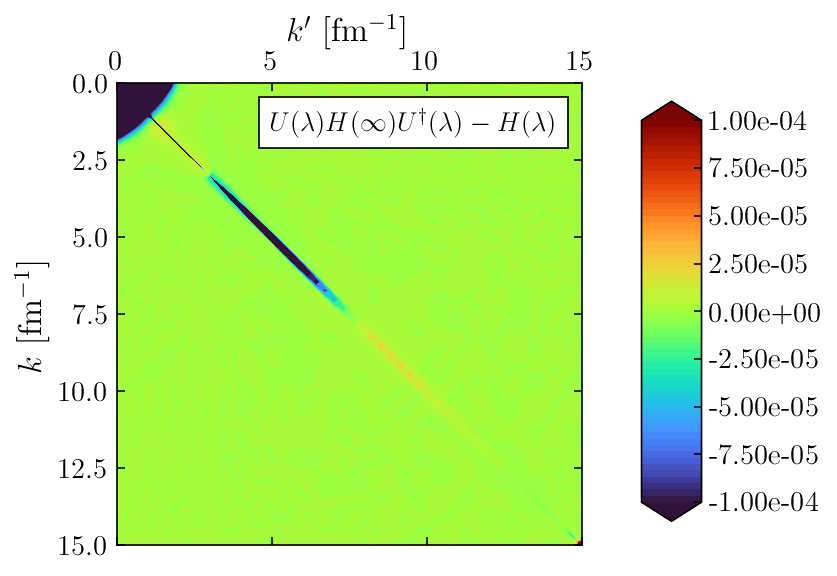

In [14]:
# Plot zero_matrix
contour_label = r"$U(\lambda) H(\infty) U^\dagger(\lambda) - H(\lambda)$"
plot_contour(
    k_array, zero_matrix_no_weights, channel, colorbar_limits=(-1e-4,1e-4),
    axes_limits=(0, 15), label=contour_label, label_size=13
)

Compare the eigenvalues of $H(\lambda)$, $U(\lambda) H(\infty) U^\dagger(\lambda)$, and $H(\infty)$.

In [15]:
eigenvalues_1, _ = la.eigh(H_evolved_weights)
eigenvalues_2, _ = la.eigh(H_evolved_weights_2)
eigenvalues_init, _ = la.eigh(H_initial_weights)

err_1 = rms_error_eigenvalues(eigenvalues_init, eigenvalues_1)
err_2 = rms_error_eigenvalues(eigenvalues_init, eigenvalues_2)

print(f"RMS error with H(\lambda) = {err_1}.")
print(f"RMS error with U H(\infty) U^\dagger = {err_2}.")

RMS error with H(\lambda) = 0.0011586648223844852.
RMS error with U H(\infty) U^\dagger = 5.808172208757572e-12.


## Solving the SRG flow equation

$$
\frac{dH}{ds} = \bigl[[H_D(s), H(s)], H(s) \bigr]
$$

In [16]:
def matrix_to_vector(M):
    """
    Takes the upper triangle of the matrix M (including the diagonal) and
    reshapes it into a vector v.
        
    Parameters
    ----------
    M : 2-D ndarray
        Input matrix of shape (N, N).
            
    Returns
    -------
    v : 1-D ndarray
        Output vector of shape (N*(N+1)/2,).
            
    """

    # Length of matrix
    N = len(M)
    # Length of vectorized matrix
    n = int(N * (N + 1) / 2)

    # Initialize vectorized matrix
    v = np.zeros(n)

    # Algorithm for reshaping M to the vector v
    i = 0
    j = N
    for k in range(N):
        v[i:j] = M[k][k:]
        i = j
        j += N - k - 1

    return v

In [17]:
def vector_to_matrix(v):
    """
    Takes the vector of an upper triangle matrix v and returns the full matrix
    M. Use only for symmetric matrices.
        
    Parameters
    ----------
    v : 1-D ndarray
        Input vector of shape (N*(N+1)/2,).
        
    Returns
    -------
    output : 2-D ndarray
        Output matrix of shape (N, N).
            
    """
    
    # Dimension of matrix is found by solving for the positive solution to
    # n = N(N+1)/2, where n is the length of the vector
    N = int((-1 + np.sqrt(1 + 8 * len(v))) / 2)

    # Initialize matrix
    M = np.zeros((N, N))

    # Build the upper half of matrix with the diagonal included

    # Algorithm for reshaping v to the matrix M
    i = 0
    j = N
    for k in range(N):
        M[k, k:] = v[i:j]
        i = j
        j += N - k - 1

    # Now reflect the upper half to lower half to build full matrix
    # M.T - np.diag(np.diag(M)) is the lower half of M excluding diagonal
    return M + (M.T - np.diag(np.diag(M)))

In [18]:
def commutator(A, B):
    """Commutator of square matrices A and B."""

    return A @ B - B @ A

In [19]:
def eta(H_matrix):
    """Wegner generator \eta = [H_D, H]."""

    # G = H_D (diagonal of the evolving Hamiltonian)
    G_matrix = np.diag(np.diag(H_matrix))

    # \eta = [G, H]
    return commutator(G_matrix, H_matrix)

In [20]:
def H_deriv(lamb, H_vector):
    """Right-hand side of the SRG flow equation."""

    # Matrix form of the evolving Hamiltonian
    H_matrix = vector_to_matrix(H_vector)

    # Get SRG generator \eta = [G, H]
    eta_matrix = eta(H_matrix)

    # RHS of the flow equation in matrix form
    dH_matrix = -4.0 / lamb ** 5 * commutator(eta_matrix, H_matrix)

    # Returns vector form of RHS of flow equation
    dH_vector = matrix_to_vector(dH_matrix)

    return dH_vector

In [21]:
def select_step_size(solver_lambda, lambda_final):
    """Select ODE solver step-size depending on the extent of evolution. We
    can take bigger steps at large values of \lambda.
    """

    if solver_lambda >= 6.0:
        dlamb = 1.0
    elif 2.5 <= solver_lambda < 6.0:
        dlamb = 0.5
    else:
        dlamb = 0.1

    # This if statement prevents the solver from over-shooting \lambda and
    # takes a step in \lambda equal to the exact amount necessary to reach 
    # lambda_final
    if solver_lambda - dlamb < lambda_final:
        dlamb = solver_lambda - lambda_final

    return dlamb

In [22]:
def get_ode_solver(lambda_initial, H_initial, atol, rtol):
    """Sets up the ODE solver."""

    # Solving for H(s)
    solver = ode(H_deriv)

    # Initial Hamiltonian as a vector
    H_initial = matrix_to_vector(H_initial)

    # Set initial conditions
    solver.set_initial_value(H_initial, lambda_initial)

    # Following the example in Hergert:2016iju with modifications to nsteps and
    # error tolerances
    solver.set_integrator('vode', method='bdf', order=5, atol=atol, rtol=rtol,
                          nsteps=5000000)

    return solver

In [23]:
def srg_evolve_wrt_lambda(
        H_initial_MeV, lambda_array, lambda_initial=20.0, atol=1e-6, rtol=1e-6
):
    """SRG evolve the Hamiltonian with respect to \lambda."""
    
    # Convert Hamiltonian from MeV to units [fm^-2]
    H_initial = H_initial_MeV / 41.47

    # Set-up ODE solver
    solver = get_ode_solver(lambda_initial, H_initial, atol, rtol)
    
    # Start time
    t0 = time.time()
    
    # Evolve the Hamiltonian to each value of \lambda and store in dictionary
    d = {}
    for lamb in lambda_array:

        # Solve ODE up to lamb and store in dictionary
        while solver.successful() and solver.t > lamb:
            
            # Get ODE solver step-size in \lambda
            dlamb = select_step_size(solver.t, lamb)

            # Integrate to next step in lambda
            solution_vector = solver.integrate(solver.t - dlamb)

        # Store evolved Hamiltonian matrix [MeV] in dictionary
        d[lamb] = vector_to_matrix(solution_vector) * 41.47

    # End time
    t1 = time.time()

    # Print details
    mins = round((t1 - t0) / 60.0, 4)  # Minutes elapsed evolving H(\lambda)
    print(f"Done evolving to \lambda = {lamb} fm^-1 after {mins:.4f} minutes.")

    return d

First solve with respect to $\lambda$ using `scipy.integrate.ode` as is done in the current code. Compare the eigenvalues of $H(\lambda)$ and $H(\infty)$ in each test run.

In [24]:
lambda_array = np.array([6.0, 3.0, 2.5, 2.0, 1.5, 1.35])
d = srg_evolve_wrt_lambda(H_initial_weights, lambda_array, lambda_initial=20.0)

Done evolving to \lambda = 1.35 fm^-1 after 1.4176 minutes.


In [25]:
# Default case (focus on last \lambda for now)
eigenvalues_evol, _ = la.eigh(d[lamb])
eigenvalues_init, _ = la.eigh(H_initial_weights)

err = rms_error_eigenvalues(eigenvalues_init, eigenvalues_evol)

print(f"RMS error in eigenvalues = {err}.")

RMS error in eigenvalues = 0.0011579950507712238.


In [26]:
# Set more stringent error tolerances
d = srg_evolve_wrt_lambda(H_initial_weights, lambda_array, lambda_initial=20.0,
                          atol=1e-10, rtol=1e-10)

eigenvalues_evol, _ = la.eigh(d[lamb])

err = rms_error_eigenvalues(eigenvalues_init, eigenvalues_evol)

print(f"RMS error in eigenvalues = {err}.")

Done evolving to \lambda = 1.35 fm^-1 after 2.0782 minutes.
RMS error in eigenvalues = 2.1887220006949626e-07.


Repeat test on $U(\lambda)$ from before but with `atol`=$10^{-10}$ and `rtol`=$10^{-10}$.

[[-9.93017043e-14 -6.90426906e-13 -2.12033079e-12 ...  7.41819303e-15
   1.78349275e-15  3.50237095e-16]
 [-6.90426907e-13 -6.41022543e-12 -1.67618179e-11 ...  2.77699374e-13
   1.78907527e-12 -6.17117369e-13]
 [-2.12033078e-12 -1.67618179e-11 -6.04718099e-11 ... -1.96213462e-12
   7.16069412e-13 -3.95241001e-13]
 ...
 [ 7.41799177e-15  2.77700045e-13 -1.96213592e-12 ...  1.29370164e-07
   4.32452723e-08  4.38281189e-08]
 [ 1.78355914e-15  1.78907475e-12  7.16068272e-13 ...  4.32452865e-08
   2.11508450e-07  1.09794721e-07]
 [ 3.50279222e-16 -6.17117380e-13 -3.95239801e-13 ...  4.38281829e-08
   1.09794732e-07  2.35251719e-07]]
3.3907702711566385e-06


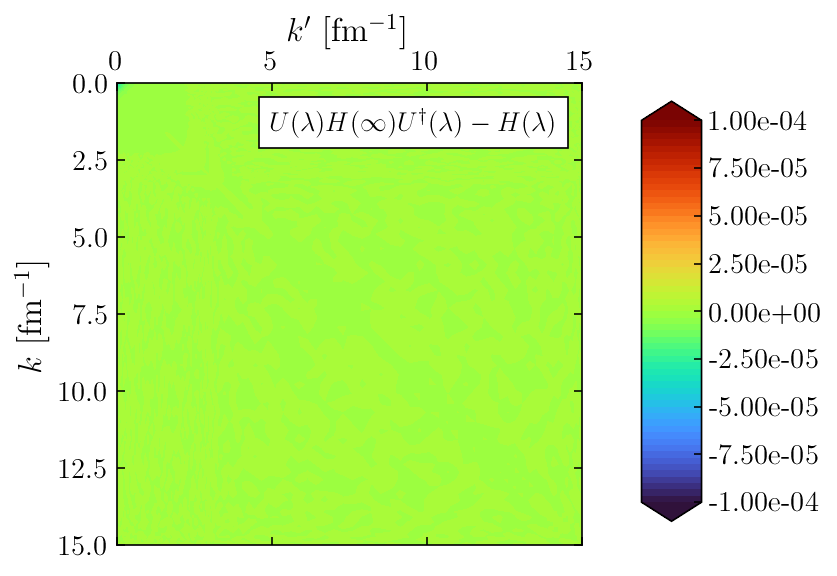

In [27]:
# SRG transformation with integration factors attached [unitless]
H_evolved_weights = d[1.35]
U_matrix_weights = get_transformation(H_initial_weights, H_evolved_weights)

H_evolved_weights_2 = U_matrix_weights @ H_initial_weights @ U_matrix_weights.T
zero_matrix_weights = H_evolved_weights_2-H_evolved_weights
print(zero_matrix_weights)
print(la.norm(zero_matrix_weights))

# Remove integration weights from zero_matrix
zero_matrix_no_weights = unattach_weights(k_array, k_weights,
                                          zero_matrix_weights)

# Plot zero_matrix
contour_label = r"$U(\lambda) H(\infty) U^\dagger(\lambda) - H(\lambda)$"
plot_contour(
    k_array, zero_matrix_no_weights, channel, colorbar_limits=(-1e-4,1e-4),
    axes_limits=(0, 15), label=contour_label, label_size=13
)

Solving with respect to $s$ using `scipy.integrate.solve_ivp`.

In [28]:
def H_deriv_s(s, H_vector):
    """Right-hand side of the SRG flow equation."""

    # Matrix form of the evolving Hamiltonian
    H_matrix = vector_to_matrix(H_vector)

    # Get SRG generator \eta = [G, H]
    eta_matrix = eta(H_matrix)

    # RHS of the flow equation in matrix form
    dH_matrix = commutator(eta_matrix, H_matrix)

    # Returns vector form of RHS of flow equation
    dH_vector = matrix_to_vector(dH_matrix)

    return dH_vector

In [29]:
def srg_evolve_wrt_s(H_initial_MeV, lambda_array, atol=1e-10, rtol=1e-10):
    """SRG evolve the Hamiltonian with respect to s."""
    
    # Convert Hamiltonian from MeV to units [fm^-2]
    H_initial_matrix = H_initial_MeV / 41.47

    # Reshape H_initial into vector
    H_initial_vector = matrix_to_vector(H_initial_matrix)
    
    # Evaluate at the following s points
    s_array = lambda_array ** (-4)
    s_limits = [0.0, s_array[-1]]
    
    # Start time
    t0 = time.time()
    result = solve_ivp(H_deriv_s, s_limits, H_initial_vector, method='BDF',
                       t_eval=s_array, atol=atol, rtol=rtol)
    # End time
    t1 = time.time()
    
    # Print details
    mins = round((t1 - t0) / 60.0, 4)  # Minutes elapsed evolving H(s)
    print(f"Done evolving to s = {s_array[-1]} fm^4 after {mins:.4f} minutes.")
    
    # Store evolved Hamiltonian matrix [MeV] in dictionary
    d = {}
    for i, lamb in enumerate(lambda_array):
        d[lamb] = vector_to_matrix(result.y[:, i]) * 41.47

    return d

In [30]:
# Use solve_ivp w.r.t. s and stringent error tolerances
d = srg_evolve_wrt_s(H_initial_weights, lambda_array)

eigenvalues_evol, _ = la.eigh(d[lamb])

err = rms_error_eigenvalues(eigenvalues_init, eigenvalues_evol)

print(f"RMS error in eigenvalues = {err}.")

Done evolving to s = 0.30106822770542724 fm^4 after 135.4456 minutes.
RMS error in eigenvalues = 1.4983596831345067e-07.


In [ ]:
# Set t_eval = None and try again (if it takes longer than 10 minutes than don't
# worry about it)

In [ ]:
# Try method="LSODA"

In [ ]:
# Try solving w.r.t. \lambda but with solve_ivp

## Solve for $U(s)$ directly

$$
\frac{dU}{ds} = \eta(s) U(s)
$$